In [1]:
import os
import numpy as np
from scipy.io import loadmat
from pyod.models.hbos import HBOS
from pysad.models.integrations import ReferenceWindowModel
from pysad.utils import ArrayStreamer
from pysad.transform.postprocessing import RunningAveragePostprocessor
from pysad.transform.preprocessing import InstanceUnitNormScaler
from pysad.transform.probability_calibration import GaussianTailProbabilityCalibrator
from tqdm.notebook import tqdm_notebook
import matplotlib.pyplot as plt
import pandas as pd
import pysad
import sklearn
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from pysad.evaluation import AUROCMetric
    
%matplotlib inline

In [2]:
data=pd.read_csv(r'C:/Users/santosh/Desktop/IoT Network Intrusion Dataset/IoT_Network_Intrusion_Dataset.csv')
data=data[['Protocol','Flow_Duration','Idle_Mean','Idle_Max','Cat','Sub_Cat','Label']]

In [4]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
data['Cat'] = label_encoder.fit_transform(data['Cat'])
data['Sub_Cat'] = label_encoder.fit_transform(data['Sub_Cat'])
data['Label'] = label_encoder.fit_transform(data['Label'])

In [5]:
mat = data[:20000]
X_all = np.array(mat.drop(['Label'],axis=1))
y_all = np.array(mat['Label'].ravel())
iterator = ArrayStreamer(shuffle=False)


### Histogram Based Outlier Score (HBOS)

In [6]:
model1 = ReferenceWindowModel(model_cls=HBOS, window_size=500, sliding_size=200, initial_window_X=X_all[:500]) # Model initialization
preprocessor = InstanceUnitNormScaler()  # Normalizer
postprocessor = RunningAveragePostprocessor(window_size=500)  # Running average postprocessor
calibrator = GaussianTailProbabilityCalibrator(running_statistics=True, window_size=6400)
y_pred_model1 = []
y_true=[]
ano_prob_model1=[]
auroc_model1 = AUROCMetric()
df=pd.DataFrame(columns=[1,2,3,4,5,6])
for i, (X, y) in tqdm_notebook(enumerate(iterator.iter(X_all[500:], y_all[500:]))):
    #print(pd.Series(X))
    df.loc[i]=X
    
    X = preprocessor.fit_transform_partial(X)
    anomaly_score = model1.fit_score_partial(X)    
    anomaly_score1 = postprocessor.fit_transform_partial(anomaly_score)
    calibrated_score1 = calibrator.fit_transform_partial(anomaly_score1)
    
    auroc_model1.update(y, calibrated_score1)
    
    ano_prob_model1.append(calibrated_score1)
    
    
    if(calibrated_score1>0.5):
        y_pred_model1.append(0)
    else:
        y_pred_model1.append(1)
    y_true.append(y)

0it [00:00, ?it/s]

In [7]:
accuracy=accuracy_score(y_true, y_pred_model1)
cm = confusion_matrix(y_true, y_pred_model1)
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (fp + tn)
score_dict_model1={'Accuracy':round(accuracy,4),'AUC':round(auroc_model1.get(),4),'Sensitivity':round(sensitivity,4),'Specificity':round(specificity,4)}
score_dict_model1

{'Accuracy': 0.2905,
 'AUC': 0.5042,
 'Sensitivity': 0.7282,
 'Specificity': 0.2607}

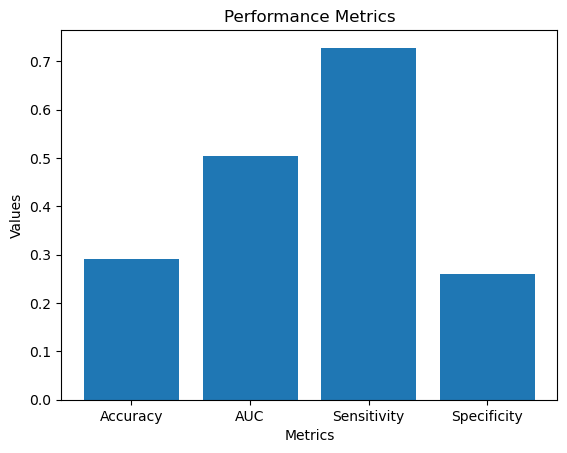

In [8]:
labels = score_dict_model1.keys()
values = score_dict_model1.values()

plt.bar(labels, values)
plt.xlabel('Metrics')
plt.ylabel('Values')

plt.title('Performance Metrics')

plt.show()

### Exact STream OutlieR Miner (Exact STORM)

In [9]:
model2 = pysad.models.ExactStorm(window_size=500) # Model initialization
preprocessor = InstanceUnitNormScaler()  # Normalizer
postprocessor = RunningAveragePostprocessor(window_size=500)  # Running average postprocessor
calibrator = GaussianTailProbabilityCalibrator(running_statistics=True, window_size=6400)
y_pred_model2 = []
y_true=[]
ano_prob_model2=[]
auroc_model2 = AUROCMetric()
df=pd.DataFrame(columns=[1,2,3,4,5,6])
for i, (X, y) in tqdm_notebook(enumerate(iterator.iter(X_all[500:], y_all[500:]))):
    #print(pd.Series(X))
    df.loc[i]=X
    
    X = preprocessor.fit_transform_partial(X)
    anomaly_score = model2.fit_score_partial(X)    
    anomaly_score2 = postprocessor.fit_transform_partial(anomaly_score)
    calibrated_score2 = calibrator.fit_transform_partial(anomaly_score2)
    
    auroc_model2.update(y, calibrated_score2)
    
    ano_prob_model2.append(calibrated_score2)
    
    
    if(calibrated_score2>0.5):
        y_pred_model2.append(0)
    else:
        y_pred_model2.append(1)
    y_true.append(y)

0it [00:00, ?it/s]

In [10]:
accuracy=accuracy_score(y_true, y_pred_model2)
cm = confusion_matrix(y_true, y_pred_model2)
tn, fp, fn, tp = cm.ravel()
#false_negative_rate = fn / (tp + fn)
#true_negative_rate = tn / (tn + fp)
sensitivity = tp / (tp + fn)
specificity = tn / (fp + tn)
score_dict_model2={'Accuracy':round(accuracy,4),'AUC':round(auroc_model2.get(),4),'Sensitivity':round(sensitivity,4),'Specificity':round(specificity,4)}
score_dict_model2

{'Accuracy': 0.5381,
 'AUC': 0.4958,
 'Sensitivity': 0.4694,
 'Specificity': 0.5428}

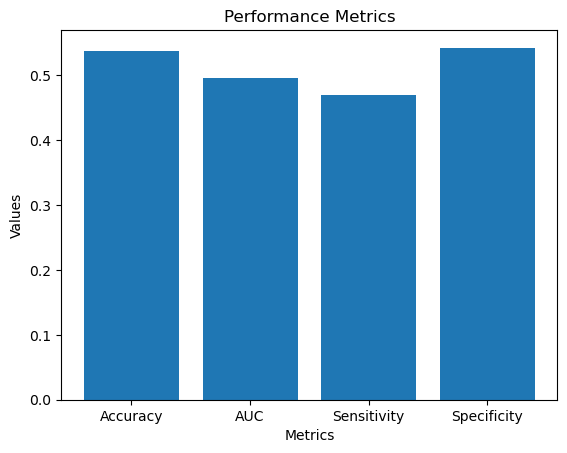

In [11]:
labels = score_dict_model2.keys()
values = score_dict_model2.values()

plt.bar(labels, values)
plt.xlabel('Metrics')
plt.ylabel('Values')

plt.title('Performance Metrics')

plt.show()

### Local Outlier Probability (LoOP)

In [12]:
model3 = pysad.models.LocalOutlierProbability(initial_X=X_all[:500]) # Model initialization
preprocessor = InstanceUnitNormScaler()  # Normalizer
postprocessor = RunningAveragePostprocessor(window_size=500)  # Running average postprocessor
calibrator = GaussianTailProbabilityCalibrator(running_statistics=True, window_size=6400)
y_pred_model3 = []
y_true=[]
ano_prob_model3=[]
auroc_model3 = AUROCMetric()
df=pd.DataFrame(columns=[1,2,3,4,5,6])
for i, (X, y) in tqdm_notebook(enumerate(iterator.iter(X_all[500:], y_all[500:]))):
    #print(pd.Series(X))
    df.loc[i]=X
    
    X = preprocessor.fit_transform_partial(X)
    anomaly_score = model3.fit_score_partial(X)    
    anomaly_score3 = postprocessor.fit_transform_partial(anomaly_score)
    calibrated_score3 = calibrator.fit_transform_partial(anomaly_score3)
    
    auroc_model3.update(y, calibrated_score3)
    
    ano_prob_model3.append(calibrated_score3)
    
    
    if(calibrated_score3>0.5):
        y_pred_model3.append(0)
    else:
        y_pred_model3.append(1)
    y_true.append(y)  

0it [00:00, ?it/s]

In [13]:
accuracy=accuracy_score(y_true, y_pred_model3)
cm = confusion_matrix(y_true, y_pred_model3)
tn, fp, fn, tp = cm.ravel()
#false_negative_rate = fn / (tp + fn)
#true_negative_rate = tn / (tn + fp)
#score_dict_model3={'Accuracy':round(accuracy,4),'AUC':round(auroc_model3.get(),4),'FNR':round(false_negative_rate,4),'TNR':round(true_negative_rate,4)}
#score_dict_model3
sensitivity = tp / (tp + fn)
specificity = tn / (fp + tn)
score_dict_model3={'Accuracy':round(accuracy,4),'AUC':round(auroc_model3.get(),4),'Sensitivity':round(sensitivity,4),'Specificity':round(specificity,4)}
score_dict_model3

{'Accuracy': 0.0636, 'AUC': 0.5, 'Sensitivity': 1.0, 'Specificity': 0.0}

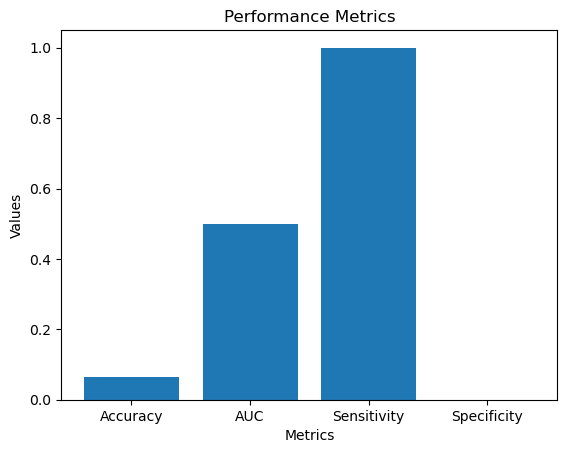

In [14]:
labels = score_dict_model3.keys()
values = score_dict_model3.values()

plt.bar(labels, values)
plt.xlabel('Metrics')
plt.ylabel('Values')

plt.title('Performance Metrics')

plt.show()

### Proposed Score Ensemblers Model

In [15]:
model1 = ReferenceWindowModel(model_cls=HBOS, window_size=500, sliding_size=200, initial_window_X=X_all[:500]) # Model initialization
model2=pysad.models.ExactStorm(window_size=500)
model3=pysad.models.LocalOutlierProbability(initial_X=X_all[:500])

preprocessor = InstanceUnitNormScaler()  # Normalizer
postprocessor = RunningAveragePostprocessor(window_size=500)  # Running average postprocessor
calibrator = GaussianTailProbabilityCalibrator(running_statistics=True, window_size=6400)  # Probability calibrator

emsembler=pysad.transform.ensemble.MedianScoreEnsembler()
auroc = AUROCMetric()

In [16]:
y_pred = []
y_true=[]
ano_prob=[]
df=pd.DataFrame(columns=[1,2,3,4,5,6])
for i, (X, y) in tqdm_notebook(enumerate(iterator.iter(X_all[500:], y_all[500:]))):
    #print(pd.Series(X))
    df.loc[i]=X
    
    X = preprocessor.fit_transform_partial(X)
    anomaly_score = model1.fit_score_partial(X)    
    anomaly_score1 = postprocessor.fit_transform_partial(anomaly_score)
    calibrated_score1 = calibrator.fit_transform_partial(anomaly_score1)
    
    model2.fit_partial(X)    
    anomaly_score2=model2.score_partial(X)
    calibrated_score2 = calibrator.fit_transform_partial(anomaly_score2)
    
    model3.fit_partial(X)    
    anomaly_score3=model3.score_partial(X)
    calibrated_score3 = calibrator.fit_transform_partial(anomaly_score3)
    
    anomaly_score_final=emsembler.fit_transform_partial(np.array([calibrated_score1,calibrated_score2,calibrated_score3]))
    
    auroc.update(y, anomaly_score_final)
    
    ano_prob.append(anomaly_score_final)
    
    
    if(anomaly_score_final>0.5):
        y_pred.append(0)
    else:
        y_pred.append(1)
    y_true.append(y)

0it [00:00, ?it/s]

## Anomaly Score for each datapoints

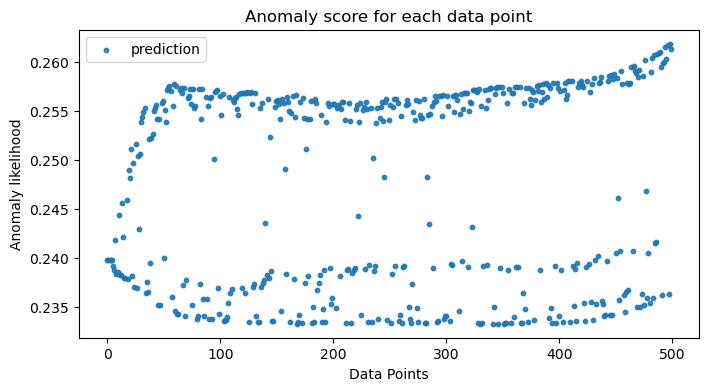

In [17]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.scatter(range(0,500),ano_prob[0:500], label='prediction', alpha = 0.9, s=10)
ax.set_xlabel('Data Points')  # Add an x-label to the axes.
ax.set_ylabel('Anomaly likelihood')  # Add a y-label to the axes.
ax.set_title(f'Anomaly score for each data point')
ax.legend()
plt.show()

## After applying thresold of 0.5

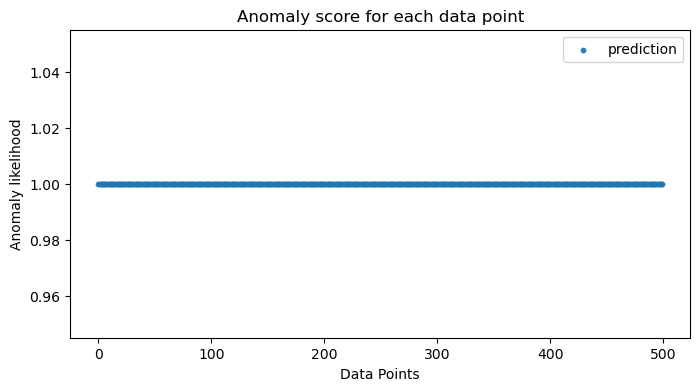

In [18]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.scatter(range(0,500),y_pred[0:500], label='prediction', alpha = 0.9, s=10)
ax.set_xlabel('Data Points')  # Add an x-label to the axes.
ax.set_ylabel('Anomaly likelihood')  # Add a y-label to the axes.
ax.set_title(f'Anomaly score for each data point')
ax.legend()
plt.show()

In [20]:
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.94      0.93      0.93     18260
           1       0.07      0.07      0.07      1240

    accuracy                           0.88     19500
   macro avg       0.50      0.50      0.50     19500
weighted avg       0.88      0.88      0.88     19500



In [21]:
accuracy=accuracy_score(y_true, y_pred)

In [22]:
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()

In [25]:
#false_negative_rate = fn / (tp + fn)
sensitivity = tp / (tp + fn)

In [26]:
#true_negative_rate = tn / (tn + fp)
specificity = tn / (fp + tn)

In [27]:
score_dict={'Accuracy':round(accuracy,4),'AUC':round(auroc.get(),4),'Sensitivity':round(sensitivity,4),'Specificity':round(specificity,4)}

In [28]:
score_dict

{'Accuracy': 0.8775,
 'AUC': 0.5062,
 'Sensitivity': 0.0694,
 'Specificity': 0.9324}

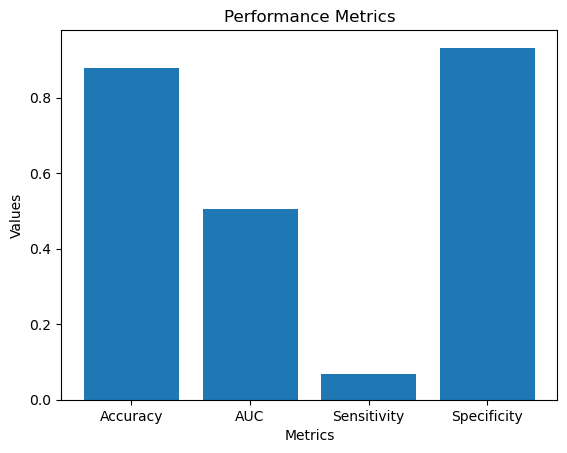

In [29]:
labels = score_dict.keys()
values = score_dict.values()

plt.bar(labels, values)
plt.xlabel('Metrics')
plt.ylabel('Values')

plt.title('Performance Metrics')

plt.show()

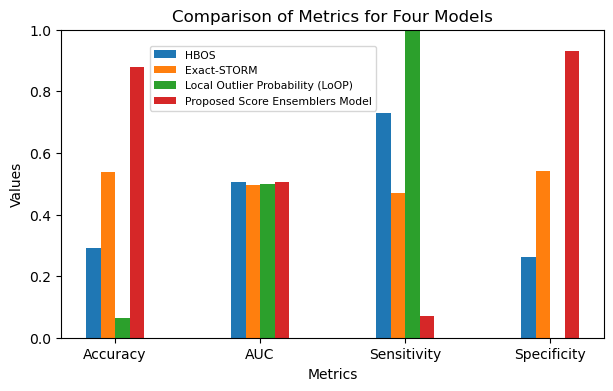

In [32]:
import matplotlib.pyplot as plt
import numpy as np


# X-axis labels
labels = list(score_dict_model1.keys())

# Values for each dictionary
values_model1 = list(score_dict_model1.values())
values_model2 = list(score_dict_model2.values())
values_model3 = list(score_dict_model3.values())
values_model4 = list(score_dict.values())

# Plotting
fig, ax = plt.subplots(figsize=(7, 4))

# Bar positions
bar_width = 0.10
spacing = 0.1
x = np.arange(len(labels))

# Plotting bars
ax.bar(x - 1.5 * (bar_width), values_model1, width=bar_width, align='center', label='HBOS')
ax.bar(x - 0.5 * bar_width, values_model2, width=bar_width, align='center', label='Exact-STORM')
ax.bar(x + 0.5 * bar_width, values_model3, width=bar_width, align='center', label='Local Outlier Probability (LoOP)')
ax.bar(x + 1.5 * bar_width, values_model4, width=bar_width, align='center', label='Proposed Score Ensemblers Model')

# X-axis settings
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_xlabel('Metrics')

# Y-axis settings
ax.set_ylim([0, 1])
ax.set_ylabel('Values')

# Legend
#ax.legend(loc='upper center', fontsize="5")
# ax.legend(loc='upper center', fontsize='6.0')
ax.legend(bbox_to_anchor=(0.5899,0.72), fontsize='7.8')
# Title
plt.title('Comparison of Metrics for Four Models')

# Show the plot
plt.show()